NLP course final project by

Armands Kurevskis

Kristaps Briks-Dravnieks

# Initial setup

In [4]:
!pip install tensorflow numpy pandas scikit-learn nltk wget emoji imbalanced-learn
import os
import wget
import pandas as pd
import numpy as np
import json
import csv
import re
import emoji
import string
from joblib import dump, load
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten
from keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB       # Naive Bayes
from sklearn.tree import DecisionTreeClassifier     # Decision Tree
from sklearn.neural_network import MLPClassifier    # Multi-Layer Perceptron
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.preprocessing import label_binarize

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=37ff2c9010b8f7829151ffddf90a94f3c3b542f252cd557d8c3eedae819b0895
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
tt = TweetTokenizer()

In [7]:
# Detailed text processing
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not",
    "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is",
    "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have", "there's": "there is",
    "here's": "here is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'
}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {
    "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ",
    "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'",
    '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta',
    '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
    '∅': '', '³': '3', 'π': 'pi', '!': ' '
}

def clean_text(text):
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:', '', text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ')
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    return text

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    text = text.strip()
    text = text.split()
    return " ".join(text)

def detailed_preprocess_text(text):
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word).upper() if word.isupper() else stemmer.stem(word).lower() for word in tokens]
    return ' '.join(tokens)

In [8]:
# Emotion mappings
emotion_list = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

general_emotion_list = [
    'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'
]

three_emotion_list = [
    'positive', 'negative', 'neutral'
]

emotion_mapping = {emotion: idx for idx, emotion in enumerate(emotion_list)}
general_emotion_mapping = {emotion: idx for idx, emotion in enumerate(general_emotion_list)}
three_emotion_mapping = {emotion: idx for idx, emotion in enumerate(three_emotion_list)}

In [ ]:
general_emotion_mapping

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'sadness': 4,
 'surprise': 5,
 'neutral': 6}

In [ ]:
three_emotion_mapping

{'positive': 0, 'negative': 1, 'neutral': 2}

# Data download and adding labels

In [9]:
# Get all pretrained models, dictionaries and mappings
def download_data():
    data_dir = 'data/goemotions_dataset'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    model_dir = 'models'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    data_urls = {
        'train': "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv",
        'dev': "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv",
        'test': "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv",
        'mapping': "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/ekman_mapping.json",
        'three_mapping': "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/three_mapping.json",
        'emotions': "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt",
        'mispell_dict': "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/mispell_dict.json"

    }

    pretrained_model_urls = {
        "NB_three_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/NB_three_model.joblib",
        "DT_three_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/DT_three_model.joblib",
        "KNN_three_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/KNN_three_model.joblib",
        "MLP_three_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/MLP_three_model.joblib",
        "NB_general_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/NB_six_model.joblib",
        "DT_general_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/DT_six_model.joblib",
        "KNN_general_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/KNN_six_model.joblib",
        "MLP_general_pretrained": "https://raw.githubusercontent.com/KristapsBD/NLP_Course/main/MLP_six_model.joblib"
    }

    for name, url in data_urls.items():
        file_path = os.path.join(data_dir, f"{name}.tsv" if name in ['train', 'dev', 'test'] else f"{name}.json" if name == 'mapping' or name == "three_mapping" or name == "mispell_dict" else f"{name}.txt")
        wget.download(url, out=file_path)

    for name, url in pretrained_model_urls.items():
        file_path = os.path.join(model_dir, f"{name}.joblib")
        wget.download(url, out=file_path)

def load_data(file_path):
    return pd.read_csv(file_path, sep='\t', header=None, names=['text', 'emotion_id', 'text_id'])

def load_json(path):
    with open(path, 'r') as file:
        return json.load(file)

In [10]:
# Initial preprocess of data, adding 3 and 6 emotion labels
def preprocess_data(df, ekman_mapping, three_mapping, emotions):
    rows = []
    for _, row in df.iterrows():
        text = row['text']
        emotion_ids = row['emotion_id'].split(',')
        for emotion_id in emotion_ids:
            emotion_id = int(emotion_id)

            # 28 emotion grouping
            emotion = emotions[emotion_id]
            emotion_label = emotion_mapping.get(emotion, len(emotion_mapping))

            # 6 emotion grouping
            general_emotion = generalize_emotions({emotion: 1}, ekman_mapping)
            general_emotion_label = general_emotion_mapping.get(general_emotion, len(general_emotion_mapping))

            # 3 emotion grouping
            three_emotion = generalize_emotions({emotion: 1}, three_mapping)
            three_emotion_label = three_emotion_mapping.get(three_emotion, len(three_emotion_mapping))

            rows.append([text, three_emotion_label, general_emotion_label, emotion_label])
    return pd.DataFrame(rows, columns=['text', 'three_emotion', 'general_emotion', 'emotion_id'])

def generalize_emotions(entry, mapping):
    for group, emotions in mapping.items():
        if any(emotion in entry for emotion in emotions):
            return group
    return "neutral"

In [11]:
# Choose text processing method - simple or detailed
text_processing_method = 'detailed'
# Choose label count - three_emotion (3 labels) or general_emotion (6 labels)
emotion_group = 'general_emotion'

In [12]:
# Download the data and initialise dataframes
download_data()

data_dir = 'data/goemotions_dataset'
train_df = load_data(os.path.join(data_dir, 'train.tsv'))
dev_df = load_data(os.path.join(data_dir, 'dev.tsv'))
test_df = load_data(os.path.join(data_dir, 'test.tsv'))

ekman_mapping = load_json(os.path.join(data_dir, 'mapping.json'))
three_mapping = load_json(os.path.join(data_dir, 'three_mapping.json'))
mispell_dict = load_json(os.path.join(data_dir, 'mispell_dict.json'))

In [ ]:
mispell_dict

{'colour': 'color',
 'centre': 'center',
 'favourite': 'favorite',
 'travelling': 'traveling',
 'counselling': 'counseling',
 'theatre': 'theater',
 'cancelled': 'canceled',
 'labour': 'labor',
 'organisation': 'organization',
 'wwii': 'World War II',
 'criticise': 'criticize',
 'youtu': 'YouTube',
 'qoura': 'Quora',
 'sallary': 'salary',
 'whta': 'what',
 'narcisist': 'narcissist',
 'howdo': 'how do',
 'whatare': 'what are',
 'howcan': 'how can',
 'howmuch': 'how much',
 'howmany': 'how many',
 'whydo': 'why do',
 'doi': 'do I',
 'thebest': 'the best',
 'howdoes': 'how does',
 'ethereum': 'Ethereum',
 'narcissit': 'narcissist',
 'bigdata': 'big data',
 '2017': '2017',
 '2018': '2018',
 'qouta': 'quota',
 'exboyfriend': 'ex-boyfriend',
 'airhostess': 'air hostess',
 'whst': 'what',
 'whatsapp': 'WhatsApp',
 'demonitization': 'demonetization',
 'demonetisation': 'demonetization',
 'absence': 'absence',
 'absense': 'absence',
 'absentse': 'absence',
 'abcense': 'absence',
 'absance': 'ab

In [13]:
# Inspect data before processing
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', None)
train_df.head()

,text,emotion_id,text_id
0,My favourite food is anything I didn't have to cook myself.,27,eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [14]:
# Aplly the initial preprocessing
with open(os.path.join(data_dir, 'emotions.txt'), 'r') as file:
    emotions = [line.strip() for line in file.readlines()]

train_df = preprocess_data(train_df, ekman_mapping, three_mapping, emotions)
dev_df = preprocess_data(dev_df, ekman_mapping, three_mapping, emotions)
test_df = preprocess_data(test_df, ekman_mapping, three_mapping, emotions)

In [ ]:
# Inspect data after adding labels
train_df.head(10)

,text,three_emotion,general_emotion,emotion_id
0,My favourite food is anything I didn't have to cook myself.,2,6,27
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",2,6,27
2,WHY THE FUCK IS BAYLESS ISOING,1,0,2
3,To make her feel threatened,1,2,14
4,Dirty Southern Wankers,1,0,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,2,5,26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,3,15
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,2,3,8
8,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,3,20
9,Damn youtube and outrage drama is super lucrative for reddit,0,3,0


# Data analysis

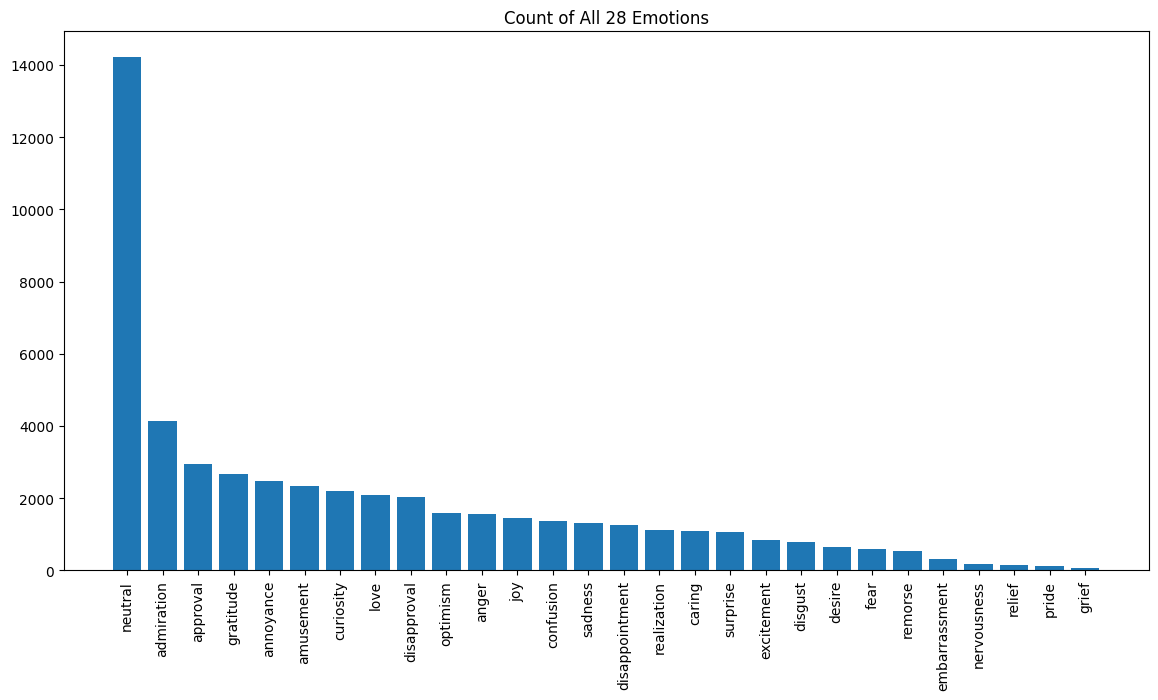

In [ ]:
# Bar chart for all 28 emotions
def generate_bar_chart(df, emotion_mapping):
    emotion_counts = df['emotion_id'].value_counts()
    emotion_labels = [list(emotion_mapping.keys())[list(emotion_mapping.values()).index(i)] for i in emotion_counts.index]
    plt.figure(figsize=(14, 7))
    plt.bar(emotion_labels, emotion_counts)
    plt.xticks(rotation=90)
    plt.title('Count of All 28 Emotions')
    plt.show()

generate_bar_chart(train_df, emotion_mapping)

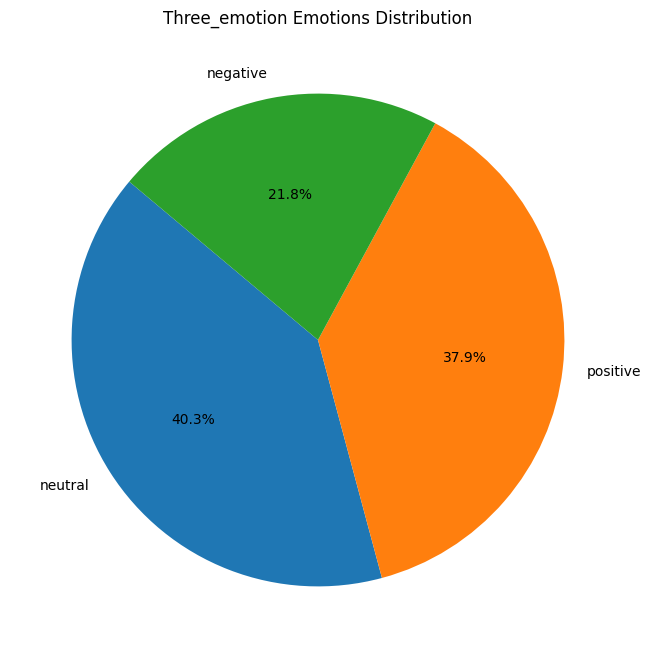

In [ ]:
# Pie charts for 3 emotion and 6 emotion groupings
def generate_pie_chart(df, group_name, mapping):
    group_counts = df[group_name].value_counts()
    labels = [list(mapping.keys())[list(mapping.values()).index(i)] for i in group_counts.index]
    plt.figure(figsize=(8, 8))
    plt.pie(group_counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'{group_name.capitalize()} Emotions Distribution')
    plt.show()

generate_pie_chart(train_df, 'three_emotion', three_emotion_mapping)

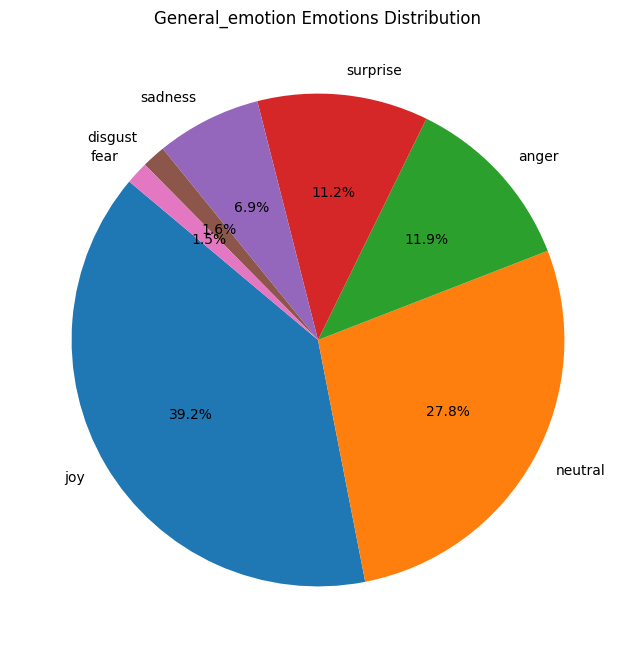

In [ ]:
generate_pie_chart(train_df, 'general_emotion', general_emotion_mapping)

# Text preprocessing

In [15]:
# Simple text preprocessing
def normalize_text(text):
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)    # e-mail addresses
    text = re.sub(r'https?://[A-Za-z0-9./-]+|www\.[A-Za-z0-9./-]+', '', text)          # URLs
    text = re.sub(r'\d+', "10", text)                                                  # numbers
    text = re.sub(r'\[NAME\]', '', text)                                               # remove patterns like "[NAME]"
    text = re.sub(r'\[RELIGION]', '', text)                                            # remove patterns like "[RELIGION]"
    return text.strip()

def simple_preprocess_text(text):
    text = normalize_text(text) # apply regex to filter out noise
    tokens = tt.tokenize(text)
    # tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]         # only keep text letters
    tokens = [word for word in tokens if word not in stop_words] # remove stop words
    tokens = [stemmer.stem(word).upper() if word.isupper() else stemmer.stem(word).lower() for word in tokens] # apply word stemming
    return ' '.join(tokens)

In [16]:
# Apply main text preprocessing
if (text_processing_method == 'detailed'):
  train_df['processed_text'] = train_df['text'].apply(detailed_preprocess_text)
  dev_df['processed_text'] = dev_df['text'].apply(detailed_preprocess_text)
  test_df['processed_text'] = test_df['text'].apply(detailed_preprocess_text)
else:
  train_df['processed_text'] = train_df['text'].apply(simple_preprocess_text)
  dev_df['processed_text'] = dev_df['text'].apply(simple_preprocess_text)
  test_df['processed_text'] = test_df['text'].apply(simple_preprocess_text)

<ipython-input-7-2cf7e7963521>:59: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()
<ipython-input-7-2cf7e7963521>:59: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()
<ipython-input-7-2cf7e7963521>:59: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [ ]:
# View processed dataframe
train_df.head(10)

,text,three_emotion,general_emotion,emotion_id,processed_text
0,My favourite food is anything I didn't have to cook myself.,2,6,27,favorit food anyth cook
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",2,6,27,everyon think he laugh screw peopl instead actual dead
2,WHY THE FUCK IS BAYLESS ISOING,1,0,2,fuck bayless iso
3,To make her feel threatened,1,2,14,make feel threaten
4,Dirty Southern Wankers,1,0,3,dirti southern wanker
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,2,5,26,omg peyton good enough help us playoff dumbass bronco fan circa decemb
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,3,15,ye heard abt f bomb thank replysquint face tongu
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,2,3,8,need board creat bit space good
8,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,3,20,need board creat bit space good
9,Damn youtube and outrage drama is super lucrative for reddit,0,3,0,damn youtubeb outrag drama super lucr reddit


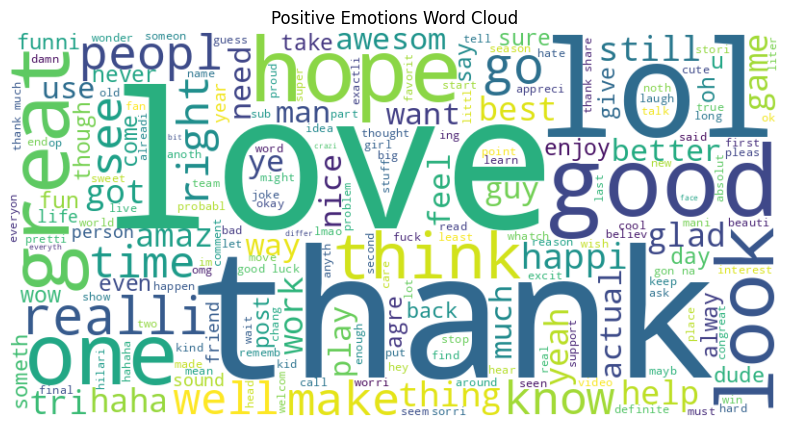

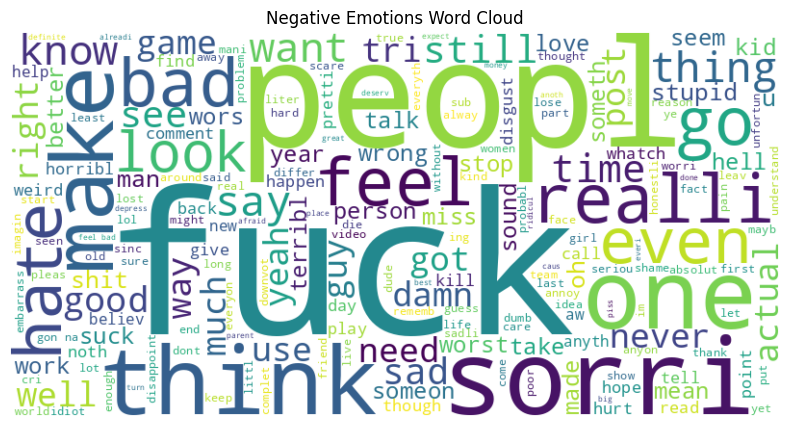

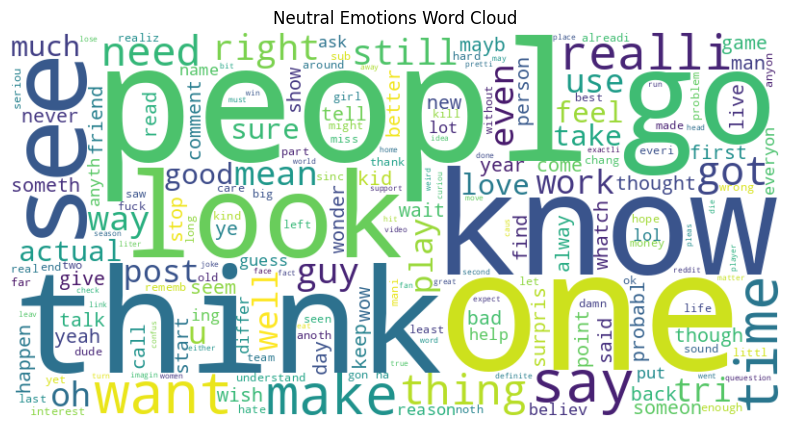

In [ ]:
# Generate word clouds
def generate_word_cloud(df, group_name):
    group_df = df[df['three_emotion'] == group_name]
    text = ' '.join(group_df['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    group_name = [key for key, value in three_emotion_mapping.items() if value == group_name]
    plt.title(f'{group_name[0].capitalize()} Emotions Word Cloud')
    plt.show()

generate_word_cloud(train_df, 0)
generate_word_cloud(train_df, 1)
generate_word_cloud(train_df, 2)

# Data splitting and vectorization

In [17]:
# Prepare data for models
x_train = train_df['processed_text']
x_dev = dev_df['processed_text']
x_test = test_df['processed_text']

y_train = train_df[emotion_group]
y_dev = dev_df[emotion_group]
y_test = test_df[emotion_group]

In [ ]:
"""Random oversampling (not supported by refactored code)"""
# def feature_generation(df, method='BOW'):
#     if method == 'BOW':
#         vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1))
#     elif method == 'TF-IDF':
#         vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1))

#     features = vectorizer.fit_transform(df['processed_text'])
#     return features, vectorizer

# ros = RandomOverSampler(random_state=42)

# x_train_resampled, y_train_resampled = ros.fit_resample(x_train.to_frame(), y_train)
# x_dev_resampled, y_dev_resampled = ros.fit_resample(x_dev.to_frame(), y_dev)

# train_features, vectorizer = feature_generation(pd.concat([x_train_resampled, x_dev_resampled]), method='BOW')
# x_train_vec = vectorizer.transform(x_train_resampled['processed_text'])
# x_dev_vec = vectorizer.transform(x_dev_resampled['processed_text'])
# x_test_vec = vectorizer.transform(x_test)

'Random oversampling (not supported by refactored code)'

In [18]:
# Split data into batches
def split_data(train_features, dev_features, train_df, dev_df):
    x_train, y_train = train_features, train_df[emotion_group]
    x_dev, y_dev = dev_features, dev_df[emotion_group]

    print("Size of dev dataset: ", x_dev.shape, y_dev.shape)
    print("Size of train dataset: ", x_train.shape, y_train.shape)

    return x_train, y_train, x_dev, y_dev

In [19]:
# Vectorize data
def feature_generation(train_df, dev_df, method = 'BOW'):
    if method == 'BOW':
        vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
        trainFeatures = vectorizer.fit_transform(train_df['processed_text'])
        devFeatures = vectorizer.transform(dev_df['processed_text'])

    if method == 'TF-IDF':
        vectorizer = TfidfVectorizer()
        trainFeatures = vectorizer.fit_transform(train_df['processed_text'])
        devFeatures = vectorizer.transform(dev_df['processed_text'])

    return trainFeatures, devFeatures, vectorizer

In [20]:
# Prepare data for model training
train_features, dev_features, vectorizer = feature_generation(train_df, dev_df, method = 'BOW')

In [21]:
x_train, y_train, x_dev, y_dev = split_data(train_features, dev_features, train_df, dev_df)

Size of dev dataset:  (6380, 17809) (6380,)
Size of train dataset:  (51103, 17809) (51103,)


In [ ]:
vectorizer

CountVectorizer(stop_words='english')

# Model training & results

In [22]:
# Model training and saving
def model(x_train, y_train, x_dev, y_dev, method = 'NB'):

    num_classes = len(y_train.unique())
    print("Class count: ", num_classes)

    if method == 'NB':
        model = MultinomialNB()

    if method == 'DT':
        model = DecisionTreeClassifier()

    if method == 'MLP':
        model = MLPClassifier()

    if method == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5)

    model = model.fit(x_train, y_train)
    predicted= model.predict(x_dev)

    y_test = label_binarize(y_dev, classes=[0, 1, 2])
    y_score = label_binarize(predicted, classes=[0, 1, 2])

    target_names = [str(i) for i in range(num_classes)]
    confusion_matrix = metrics.confusion_matrix(y_dev, predicted)

    print(classification_report(y_dev, predicted, target_names=target_names))
    print(confusion_matrix)

    # Save the model
    # model_filename = f"{method}_model.joblib"
    # dump(model, model_filename)
    # print(f"Saved {method} model as {model_filename}")

    return model

In [ ]:
k_nearest_neighbours = model(x_train, y_train, x_dev, y_dev, method = 'KNN')

Class count:  7
              precision    recall  f1-score   support

           0       0.37      0.25      0.30       790
           1       0.38      0.19      0.25        97
           2       0.48      0.20      0.28       111
           3       0.64      0.72      0.68      2538
           4       0.55      0.26      0.36       422
           5       0.22      0.16      0.19       656
           6       0.43      0.53      0.47      1766

    accuracy                           0.51      6380
   macro avg       0.44      0.33      0.36      6380
weighted avg       0.49      0.51      0.49      6380

[[ 200    8    3  194   13   67  305]
 [  16   18    2   22    2    5   32]
 [   9    4   22   28    3   19   26]
 [  89    7    9 1833   37   95  468]
 [  28    3    5  115  111   30  130]
 [  51    2    3  201   16  107  276]
 [ 152    5    2  487   21  164  935]]


In [ ]:
decision_trees = model(x_train, y_train, x_dev, y_dev, method = 'DT')

Class count:  7
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       790
           1       0.30      0.34      0.32        97
           2       0.38      0.34      0.36       111
           3       0.67      0.75      0.71      2538
           4       0.41      0.36      0.38       422
           5       0.28      0.24      0.26       656
           6       0.48      0.47      0.48      1766

    accuracy                           0.52      6380
   macro avg       0.41      0.40      0.40      6380
weighted avg       0.51      0.52      0.52      6380

[[ 247   29    6  160   37   64  247]
 [  20   33    3   19    5    4   13]
 [   9    5   38   22    5   13   19]
 [ 125    7   20 1891   67  106  322]
 [  49   13    9  103  151   24   73]
 [  63    8    8  179   37  155  206]
 [ 231   14   15  436   62  181  827]]


In [ ]:
naive_bayes = model(x_train, y_train, x_dev, y_dev, method = 'NB')

Class count:  7
              precision    recall  f1-score   support

           0       0.47      0.26      0.33       790
           1       0.44      0.04      0.08        97
           2       0.67      0.04      0.07       111
           3       0.59      0.85      0.70      2538
           4       0.63      0.21      0.31       422
           5       0.47      0.14      0.21       656
           6       0.46      0.51      0.48      1766

    accuracy                           0.54      6380
   macro avg       0.53      0.29      0.31      6380
weighted avg       0.53      0.54      0.50      6380

[[ 205    1    0  249    9   15  311]
 [  29    4    0   40    0    4   20]
 [  10    0    4   57    3    0   37]
 [  42    0    1 2159   13   34  289]
 [  19    0    0  187   88   10  118]
 [  26    1    0  272    7   90  260]
 [ 104    3    1  709   19   37  893]]


In [ ]:
multi_layer_perceptron = model(x_train, y_train, x_dev, y_dev, method = 'MLP')

Class count:  7
              precision    recall  f1-score   support

           0       0.35      0.30      0.32       790
           1       0.38      0.27      0.31        97
           2       0.53      0.41      0.46       111
           3       0.69      0.71      0.70      2538
           4       0.43      0.35      0.38       422
           5       0.26      0.21      0.23       656
           6       0.45      0.53      0.48      1766

    accuracy                           0.52      6380
   macro avg       0.44      0.40      0.41      6380
weighted avg       0.51      0.52      0.51      6380

[[ 236   20    3  142   35   57  297]
 [  22   26    3   20    2    5   19]
 [   7    1   46   22    5    7   23]
 [ 109    5   14 1801   72  125  412]
 [  44    4    3   81  147   38  105]
 [  53    1    8  146   30  137  281]
 [ 207   12   10  391   54  164  928]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# Pretrained models inference

In [23]:
# Inference function
def predict_emotion(text, vectorizer, emotion_group):

    # Load saved models
    if (emotion_group == 'general_emotion'):
      nb_model = load('models/NB_general_pretrained.joblib')
      dt_model = load('models/DT_general_pretrained.joblib')
      mlp_model = load('models/MLP_general_pretrained.joblib')
      knn_model = load('models/KNN_general_pretrained.joblib')
    else:
      nb_model = load('models/NB_three_pretrained.joblib')
      dt_model = load('models/DT_three_pretrained.joblib')
      mlp_model = load('models/MLP_three_pretrained.joblib')
      knn_model = load('models/KNN_three_pretrained.joblib')

    # Preprocess the input text
    if (text_processing_method == 'detailed'):
      processed_text = detailed_preprocess_text(text)
    else:
      processed_text = simple_preprocess_text(text)


    # Naive Bayes, Decision Tree, MLP, KNN predictions
    vectorized_text = vectorizer.transform([processed_text])
    knn_pred = knn_model.predict(vectorized_text)[0]
    dt_pred = dt_model.predict(vectorized_text)[0]
    nb_pred = nb_model.predict(vectorized_text)[0]
    mlp_pred = mlp_model.predict(vectorized_text)[0]

    if (emotion_group == 'general_emotion'):
      emotion_labels = {v: k for k, v in general_emotion_mapping.items()}
    else:
      emotion_labels = {v: k for k, v in three_emotion_mapping.items()}

    print("KNN Prediction:", emotion_labels[knn_pred])
    print("Decision Tree Prediction:", emotion_labels[dt_pred])
    print("Naive Bayes Prediction:", emotion_labels[nb_pred])
    print("MLP Prediction:", emotion_labels[mlp_pred])

In [30]:
input_text = "I am so happy today!"
predict_emotion(input_text, vectorizer, emotion_group)

KNN Prediction: joy
Decision Tree Prediction: joy
Naive Bayes Prediction: joy
MLP Prediction: joy


# BERT demo

In [25]:
import requests
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, logging

logging.set_verbosity_error()

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the BERT model class
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(768, 28)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

# Download the model weights from Dropbox
url = "https://www.dropbox.com/scl/fi/5q1lpgqtrks8j2vfrwb4s/bert_model_weights_28label.pth?rlkey=fvnigkehdtvcjp3grp0vgv50g&st=ubfco31v&dl=1"
response = requests.get(url)
model_path = 'bert_model_weights_28label.pth'
with open(model_path, 'wb') as file:
    file.write(response.content)

# Initialize the Model
model = BERTClass()
model.to(device)

# Load the weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load emotion labels
emotion_labels = []
with open(data_dir + '/emotions.txt', 'r') as file:
    emotion_labels = [line.strip() for line in file.readlines()]


In [34]:
def run_inference():
    while True:
        text = input("\nEnter a text to classify: ")
        if len(text) == 0: break

        # Tokenize the input text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Run inference
        with torch.no_grad():
            outputs = model(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'])

        # Get the predicted class
        predicted_class_idx = torch.argmax(outputs, dim=1).item()
        predicted_class_label = emotion_labels[predicted_class_idx]
        print("\nPrediction:", predicted_class_label)

run_inference()


Enter a text to classify: i think you are wrong

Prediction: disapproval

Enter a text to classify: i am happy today

Prediction: joy

Enter a text to classify: i feel stressed

Prediction: caring

Enter a text to classify: this is amazing

Prediction: admiration

Enter a text to classify: i like this

Prediction: neutral

Enter a text to classify: i am very happy

Prediction: joy


KeyboardInterrupt: Interrupted by user